In [9]:
# =====================================================
# 🖐️ Hand Gesture Recognition - MobileNetV2 Fine-tuned
# =====================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [11]:
# =====================================================
# 📁 Load Dataset
# =====================================================

data_path = r"C:\Users\Enter Computer\OneDrive\Desktop\leapGestRecog"  # غيّري ده حسب جهازك
img_size = 128

X, y, subjects = [], [], []

gesture_folders = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
    '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
]

for subject in sorted(os.listdir(data_path)):
    subject_path = os.path.join(data_path, subject)
    if not os.path.isdir(subject_path):
        continue

    for gesture in gesture_folders:
        gesture_path = os.path.join(subject_path, gesture)
        if not os.path.isdir(gesture_path):
            continue

        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(gesture)
            subjects.append(subject)

X = np.array(X, dtype="float32")
y = np.array(y)
subjects = np.array(subjects)

print("✅ Total samples:", X.shape[0])


✅ Total samples: 19600


In [13]:
# =====================================================
# 🧩 Encode Labels
# =====================================================
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(np.unique(y)))

In [15]:
# =====================================================
# ✂️ Split by Subjects (No Leakage)
# =====================================================
train_subjects = ["00","01","02","03","04","05"]
val_subjects   = ["08","06"]
test_subjects  = ["09","07"]
print("Subjects in Train:", np.unique(subjects[np.isin(subjects, train_subjects)]))
print("Subjects in Val:", np.unique(subjects[np.isin(subjects, val_subjects)]))
print("Subjects in Test:", np.unique(subjects[np.isin(subjects, test_subjects)]))


X_train = X[np.isin(subjects, train_subjects)]
y_train = y_cat[np.isin(subjects, train_subjects)]

X_val = X[np.isin(subjects, val_subjects)]
y_val = y_cat[np.isin(subjects, val_subjects)]

X_test = X[np.isin(subjects, test_subjects)]
y_test = y_cat[np.isin(subjects, test_subjects)]

print(f"📊 Split done:\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Subjects in Train: ['00' '01' '02' '03' '04' '05']
Subjects in Val: ['06' '08']
Subjects in Test: ['07' '09']
📊 Split done:
Train: (11600, 128, 128), Val: (4000, 128, 128), Test: (4000, 128, 128)


In [17]:
# =====================================================
# 🖼️ Ensure correct dimensions
# =====================================================
if X_train.ndim == 3:
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

In [18]:
# =====================================================
# 🎨 Convert grayscale → RGB (3 channels)
# =====================================================
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb   = np.repeat(X_val, 3, axis=-1)
X_test_rgb  = np.repeat(X_test, 3, axis=-1)

print("🖼️ Shapes after RGB conversion:")
print("Train:", X_train_rgb.shape)
print("Val:", X_val_rgb.shape)
print("Test:", X_test_rgb.shape)


🖼️ Shapes after RGB conversion:
Train: (11600, 128, 128, 3)
Val: (4000, 128, 128, 3)
Test: (4000, 128, 128, 3)


In [19]:
# =====================================================
# ⚙️ Data Generators
# =====================================================

# 🧠 Augmentation متقدم جدًا
train_datagen = ImageDataGenerator(
    rescale=1./255,
    
    # حركات وتحولات مكانية
    rotation_range=45,          # دوران الإيد لحد 45°
    width_shift_range=0.25,     # تحريك أفقي
    height_shift_range=0.25,    # تحريك رأسي
    shear_range=0.3,            # ميل اليد
    zoom_range=[0.7, 1.4],      # تقريب أو تصغير
    
    # إضاءات وألوان
    brightness_range=[0.3, 1.7],   # من إضاءة منخفضة جدًا لعالية جدًا
    channel_shift_range=40.0,      # تغير لون الجلد والإضاءة
    
    # تشويش وتنوع
    horizontal_flip=True,          # قلب الصورة أفقيًا (زي الإيد اليمين والشمال)
    fill_mode='nearest',           # ملء الفراغات بعد التحويل
)



test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen_rgb = train_datagen.flow(X_train_rgb, y_train, batch_size=64, shuffle=True)
val_gen_rgb   = test_val_datagen.flow(X_val_rgb, y_val, batch_size=64, shuffle=False)
test_gen_rgb  = test_val_datagen.flow(X_test_rgb, y_test, batch_size=64, shuffle=False)


In [21]:
# =====================================================
# 📞 Callbacks
# =====================================================
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_cnn(6).keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


In [22]:
# =====================================================
# 🧠 Build MobileNetV2 Model
# =====================================================
num_classes = len(le.classes_)
base = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Freeze 80% of layers
for layer in base.layers[:130]:
    layer.trainable = False
for layer in base.layers[130:]:
    layer.trainable = True

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=base.input, outputs=out)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 1,525,258 (5.82 MB)

 Non-trainable params: 897,984 (3.43 MB)

In [23]:
# =====================================================
# 🚀 Training
# =====================================================
history_mobilenet = mobilenet_model.fit(
    train_gen_rgb,
    validation_data=val_gen_rgb,
    epochs=6,
    callbacks=callbacks
)

C:\Users\Enter Computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.1753 - loss: 2.5701  
Epoch 1: val_loss improved from None to 1.65590, saving model to best_cnn(6).keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 202s 987ms/step - accuracy: 0.2509 - loss: 2.2440 - val_accuracy: 0.4132 - val_loss: 1.6559 - learning_rate: 1.0000e-05
Epoch 2/6
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.4915 - loss: 1.5153  
Epoch 2: val_loss improved from 1.65590 to 1.00647, saving model to best_cnn(6).keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5550 - loss: 1.3483 - val_accuracy: 0.6702 - val_loss: 1.0065 - learning_rate: 1.0000e-05
Epoch 3/6
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.6900 - loss: 0.9706  
Epoch 3: val_loss improved from 1.00647 to 0.68474, saving model to best_cnn(6).keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 177s 971ms/step - accuracy: 0.7294 - loss: 0.8765 - val_accuracy: 0.7680 - val_loss: 0.6847 - learning_rate: 1.0000e-05
Epoch 4/6
182/182 ━━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.9265 - loss: 0.2816    

✅ Test Accuracy: 92.65%
💡 Test Loss: 0.2816
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 444ms/step - accuracy: 0.9265 - loss: 0.2816    

✅ Test Accuracy: 92.65%
💡 Test Loss: 0.2816
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 462ms/step

📋 Classification Report:
               precision    recall  f1-score   support

      01_palm       0.95      1.00      0.97       400
         02_l       1.00      0.81      0.90       400
      03_fist       0.87      0.94      0.90       400
04_fist_moved       0.74      1.00      0.85       400
     05_thumb       1.00      0.86      0.93       400
     06_index       0.84      0.96      0.89       400
        07_ok       1.00      1.00      1.00       400
08_palm_moved       1.00      0.96      0.98       400
         09_c       1.00      0.73      0.84       400
      10_down       1.00      1.00      1.00       400

     accuracy                           0.93      4000
    macro avg       

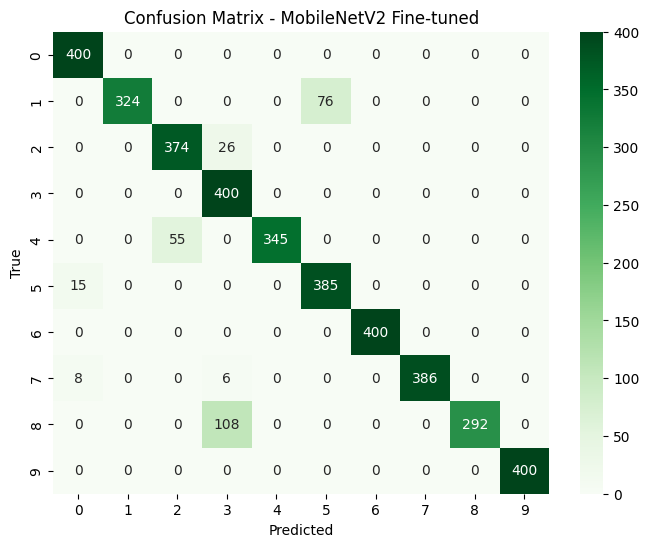

In [24]:
# =====================================================
# 🧾 Evaluation on Test Set
# =====================================================
test_loss, test_acc = mobilenet_model.evaluate(test_gen_rgb, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"💡 Test Loss: {test_loss:.4f}")

# 🧾 Evaluation on Test Set (بدون double normalization)
test_loss, test_acc = mobilenet_model.evaluate(test_gen_rgb, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"💡 Test Loss: {test_loss:.4f}")

# ✅ استخدمي generator مباشرة للتنبؤ، مش /255.0 تاني
y_pred = mobilenet_model.predict(test_gen_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - MobileNetV2 Fine-tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



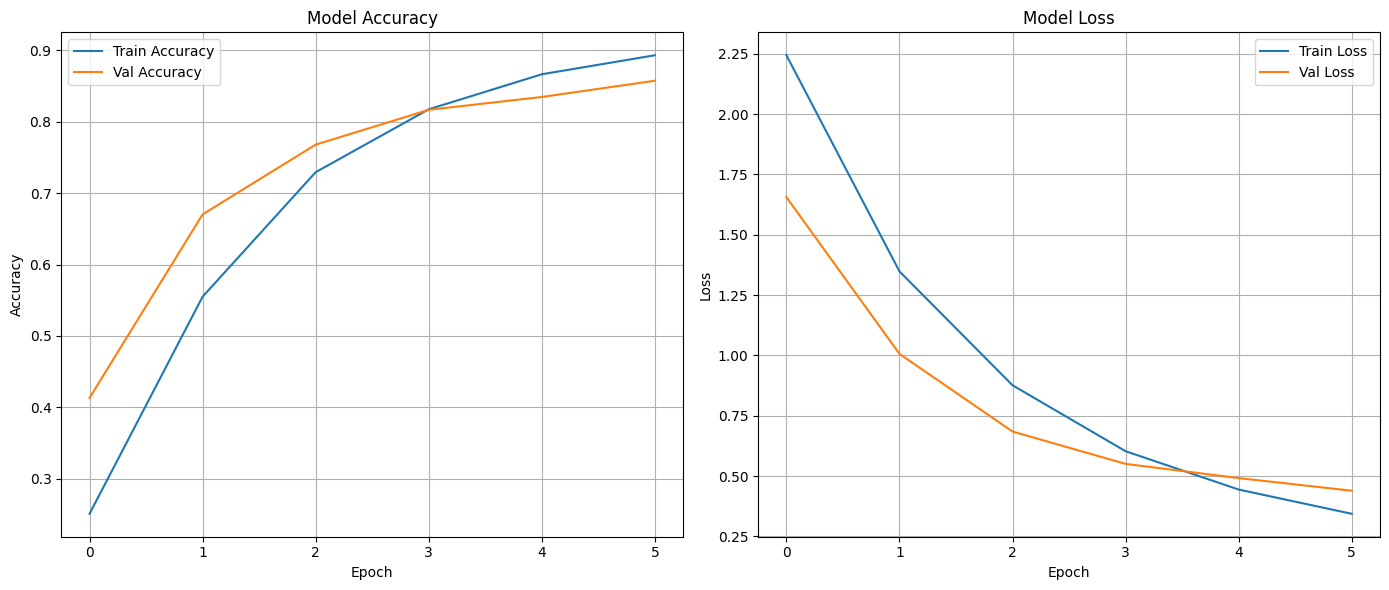

In [25]:
# =====================================================
# 📊 Plot Training Curves (Accuracy & Loss)
# =====================================================
import matplotlib.pyplot as plt

# Assuming your fit output is saved as 'history'
hist = history_mobilenet.history

plt.figure(figsize=(14, 6))

# -------- Accuracy Plot --------
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -------- Loss Plot --------
plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

# ----------------------------------------
# الإعدادات الأساسية
# ----------------------------------------
base_path = r"C:\Users\Enter Computer\OneDrive\Desktop\leapGestRecog"   # مسار المشروع عندك
IMG_SIZE = 128
model_path = r"C:\Users\Enter Computer\Downloads\best_cnn.keras"  # عدليه بمسار الموديل بتاعك
model = load_model(model_path)

# ----------------------------------------
# أسماء الإيماءات (زي اللي استخدمتيها في التدريب)
# ----------------------------------------
gestures = ['palm', 'ok', '03_fist', '04_fist_moved', '05_thumb', 
             '06_index', '08_palm_moved', '09_c', '10_down']

# ----------------------------------------
# دالة لتحميل بيانات شخص معين
# ----------------------------------------
def load_subject_data(subject_folder):
    X, y = [], []
    for gesture_folder in gestures:
        folder_path = os.path.join(subject_folder, gesture_folder)
        if not os.path.exists(folder_path):
            continue
        for img_name in os.listdir(folder_path):
            if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img = img / 255.0
                    X.append(img)
                    y.append(gestures.index(gesture_folder))
    return np.array(X), np.array(y)

# ----------------------------------------
# حساب الدقة لكل subject
# ----------------------------------------
subject_accs = {}

for subject_folder in sorted(os.listdir(base_path)):
    full_path = os.path.join(base_path, subject_folder)
    if not os.path.isdir(full_path):
        continue

    print(f"📂 Loading data for subject {subject_folder}...")
    X_subj, y_subj = load_subject_data(full_path)

    if len(X_subj) == 0:
        print(f"⚠️ No images found for subject {subject_folder}")
        continue

    y_pred_probs = model.predict(X_subj)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_subj, y_pred)
    subject_accs[subject_folder] = acc
    print(f"✅ Subject {subject_folder} accuracy: {acc:.3f}")

# ----------------------------------------
# عرض النتائج
# ----------------------------------------
print("\n📊 Per-Subject Accuracy:")
for s, acc in subject_accs.items():
    print(f"Subject {s}: {acc:.3f}")

print(f"\n🎯 Overall mean accuracy: {np.mean(list(subject_accs.values())):.3f}")


📂 Loading data for subject 00...
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step
✅ Subject 00 accuracy: 0.570
📂 Loading data for subject 01...
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step 
✅ Subject 01 accuracy: 0.557
📂 Loading data for subject 02...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step
✅ Subject 02 accuracy: 0.570
📂 Loading data for subject 03...
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step
✅ Subject 03 accuracy: 0.570
📂 Loading data for subject 04...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step
✅ Subject 04 accuracy: 0.557
📂 Loading data for subject 05...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step
✅ Subject 05 accuracy: 0.571
📂 Loading data for subject 06...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step
✅ Subject 06 accuracy: 0.571
📂 Loading data for subject 07...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step
✅ Subject 07 accuracy: 0.571
📂 Loading data for subject 08...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step
✅ Subject 08 accuracy: 0.499
📂 Loading data for subject 09...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step

In [5]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import tensorflow as tf

# =====================================================
# ⚙️ الإعدادات الأساسية
# =====================================================
subjects_all = sorted(np.unique(subjects))
num_classes = len(np.unique(y))
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=num_classes)

# تحويل البيانات لشكل مناسب
if X.ndim == 3:
    X = np.expand_dims(X, axis=-1)
X_rgb = np.repeat(X, 3, axis=-1)
X_rgb = X_rgb / 255.0

# =====================================================
# ⚙️ Augmentation أقوى (للتعميم)
# =====================================================
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator()

# =====================================================
# 🧠 بناء نموذج MobileNetV2
# =====================================================
def build_model(num_classes):
    base = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    for layer in base.layers[:100]:
        layer.trainable = False
    for layer in base.layers[100:]:
        layer.trainable = True
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# =====================================================
# 🌀 LOSO Evaluation
# =====================================================
subject_accuracies = []

for test_subject in subjects_all:
    print(f"\n===============================")
    print(f"🎯 Testing on subject: {test_subject}")
    print(f"===============================")

    # تقسيم البيانات
    train_mask = subjects != test_subject
    test_mask = subjects == test_subject

    X_train, y_train = X_rgb[train_mask], y_cat[train_mask]
    X_test, y_test = X_rgb[test_mask], y_cat[test_mask]

    train_gen = train_datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
    test_gen = test_datagen.flow(X_test, y_test, batch_size=64, shuffle=False)

    # بناء النموذج
    model = build_model(num_classes)

    # callbacks بسيطة
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=0)
    ]

    # تدريب مختصر (تقديريًا 5 epochs لكل subject)
    model.fit(
        train_gen,
        epochs=5,
        validation_data=test_gen,
        callbacks=callbacks,
        verbose=1
    )

    # التقييم
    loss, acc = model.evaluate(test_gen, verbose=0)
    subject_accuracies.append(acc)
    print(f"✅ Subject {test_subject} accuracy: {acc*100:.2f}%")

# =====================================================
# 📊 عرض النتيجة النهائية
# =====================================================
mean_acc = np.mean(subject_accuracies)
print("\n===============================")
print("📊 LOSO Evaluation Results")
for s, a in zip(subjects_all, subject_accuracies):
    print(f"Subject {s}: {a*100:.2f}%")
print(f"\n🎯 Mean Cross-Subject Accuracy: {mean_acc*100:.2f}%")
print("===============================")



🎯 Testing on subject: 00


C:\Users\Enter Computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 469ms/step - accuracy: 0.0964 - loss: 2.3279 - val_accuracy: 0.1680 - val_loss: 2.2945 - learning_rate: 1.0000e-04
Epoch 2/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 127s 462ms/step - accuracy: 0.1013 - loss: 2.3042 - val_accuracy: 0.1800 - val_loss: 2.2756 - learning_rate: 1.0000e-04
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 129s 468ms/step - accuracy: 0.1028 - loss: 2.3031 - val_accuracy: 0.0660 - val_loss: 2.2941 - learning_rate: 1.0000e-04
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 129s 468ms/step - accuracy: 0.0997 - loss: 2.3029 - val_accuracy: 0.0375 - val_loss: 2.3432 - learning_rate: 1.0000e-04
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 128s 466ms/step - accuracy: 0.1021 - loss: 2.3023 - val_accuracy: 0.0430 - val_loss: 2.3423 - learning_rate: 3.0000e-05
✅ Subject 00 accuracy: 18.00%

🎯 Testing on subject: 01
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - accuracy: 0.0997 - loss: 2.3269 - val_accuracy: 0.1019 - val_loss: 2.1011 - learning_rate: 1

MemoryError: Unable to allocate 3.22 GiB for an array with shape (17600, 128, 128, 3) and data type float32

In [6]:
import numpy as np

# استخدمي نفس المتغيرات اللي في كودك
train_subjects = ["00","01","02","03","04","05","06","07"]
val_subjects   = ["08"]
test_subjects  = ["09"]

print("train_subjects:", train_subjects)
print("val_subjects:", val_subjects)
print("test_subjects:", test_subjects)

# لو عندك مصفوفة subjects لكل عينة (زي subjects المتولدة أثناء التحميل)
print("unique subjects in dataset:", np.unique(subjects))
print("subjects in train (from data):", np.unique(subjects[np.isin(subjects, train_subjects)]))
print("subjects in val:", np.unique(subjects[np.isin(subjects, val_subjects)]))
print("subjects in test:", np.unique(subjects[np.isin(subjects, test_subjects)]))


train_subjects: ['00', '01', '02', '03', '04', '05', '06', '07']
val_subjects: ['08']
test_subjects: ['09']
unique subjects in dataset: ['00' '01' '02' '03' '04' '05' '06' '07' '08' '09']
subjects in train (from data): ['00' '01' '02' '03' '04' '05' '06' '07']
subjects in val: ['08']
subjects in test: ['09']


In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
IMG_SIZE=128
base = MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')

# جمد معظم الطبقات، وافتح آخر أجزاء قليلة
for layer in base.layers[:140]:
    layer.trainable = False
for layer in base.layers[140:]:
    layer.trainable = True

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 1,205,258 (4.60 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint("model_2.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]

history = model.fit(
    train_gen_rgb,
    validation_data=val_gen_rgb,
    epochs=5,
    callbacks=callbacks,
    
)


In [28]:
# evaluate
test_loss, test_acc = model.evaluate(test_gen)
print("Test acc:", test_acc, "loss:", test_loss)

# detailed report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=le.classes_))


NameError: name 'test_gen' is not defined

In [ ]:
# =====================================================
# 📊 Plot Training Curves (Accuracy & Loss)
# =====================================================
import matplotlib.pyplot as plt

# Assuming your fit output is saved as 'history'
hist = history.history

plt.figure(figsize=(14, 6))

# -------- Accuracy Plot --------
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -------- Loss Plot --------
plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
